In [1]:
import pandas as pd

import classification

## Process corpora in classic pipeline

1. Tokenization
2. Vectorization
3. TF-IDF
4. Hyperparameter optimization
5. Training
6. Evaluation

Classic algorithms are:
- Random
- Naïve Bayes
- Logistic Regression
- Support Vector Machine

In [2]:
scores = list()

for corpus in {"wikipedia", "dramen", "zeitung", "romane"}:
    score = dict(classification.classic_pipeline(corpus, downsample=False))
    score = pd.Series(score)
    score.name = corpus.capitalize()
    scores.append(score)

scores = pd.DataFrame(scores).round(4).T

In [3]:
scores

,Wikipedia,Zeitung,Romane,Dramen
Random,0.32,0.27,0.40,0.39
Naïve Bayes,1.00,0.96,0.71,0.61
Logistic Regression,1.00,0.97,0.70,0.94
Support Vector Machine,1.00,0.96,0.71,0.67


## Process corpora in neural pipeline

1. Tokenization
2. Fine-tuning
6. Evaluation

Neural models are:
- German BERT

In [8]:
from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.data import Corpus
from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

# this is the folder in which train, test and dev files reside
data_folder = 'classification/data/flair/split'

# load corpus containing training, test and dev data
corpus: Corpus = ClassificationCorpus(data_folder,
                                      test_file='romane-test-flair.txt',
                                      dev_file='romane-val-flair.txt',
                                      train_file='romane-train-flair.txt')

2019-08-26 16:39:44,322 Reading data from classification/data/flair/split
2019-08-26 16:39:44,323 Train: classification/data/flair/split/romane-train-flair.txt
2019-08-26 16:39:44,324 Dev: classification/data/flair/split/romane-val-flair.txt
2019-08-26 16:39:44,325 Test: classification/data/flair/split/romane-test-flair.txt


In [14]:
corpus.train[22]

Sentence: "» Siehe , wozu mich heute der Gehorsam verdammt ." - 10 Tokens

In [9]:
# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('de'),

                   # comment in flair embeddings for state-of-the-art results
                   # FlairEmbeddings('news-forward'),
                   # FlairEmbeddings('news-backward'),
                   ]

# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

2019-08-26 16:39:46,966 {'1', '2', '0'}


In [10]:

# 7. start the training
trainer.train('test-zeitung',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=5)

2019-08-26 16:40:03,633 ----------------------------------------------------------------------------------------------------
2019-08-26 16:40:03,635 Evaluation method: MICRO_F1_SCORE
2019-08-26 16:40:04,006 ----------------------------------------------------------------------------------------------------
2019-08-26 16:40:05,042 epoch 1 - iter 0/40 - loss 1.11759722
2019-08-26 16:40:08,518 epoch 1 - iter 4/40 - loss 1.05342314
2019-08-26 16:40:10,916 epoch 1 - iter 8/40 - loss 1.04623997
2019-08-26 16:40:13,449 epoch 1 - iter 12/40 - loss 1.03089637
2019-08-26 16:40:16,801 epoch 1 - iter 16/40 - loss 1.02999891
2019-08-26 16:40:20,782 epoch 1 - iter 20/40 - loss 1.03822716
2019-08-26 16:40:24,940 epoch 1 - iter 24/40 - loss 1.03750018
2019-08-26 16:40:28,639 epoch 1 - iter 28/40 - loss 1.03812209
2019-08-26 16:40:31,201 epoch 1 - iter 32/40 - loss 1.03477837
2019-08-26 16:40:34,554 epoch 1 - iter 36/40 - loss 1.03636513
2019-08-26 16:40:37,087 -----------------------------------------

Traceback (most recent call last):
  File "/home/severin/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/home/severin/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/severin/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/severin/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/severin/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/severin/.pyenv/versions/3.7.2/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/severin/.pyenv/versi

KeyboardInterrupt: 

In [1]:
from classification import preprocessing

In [3]:
from pathlib import Path

for file in Path("classification/data").glob("**/*.json"):
    preprocessing.convert_flair_data(file)

In [ ]:
from classification import preprocessing

dataset = preprocessing.load(corpus, split=True)
if downsample:
    dataset = preprocessing.downsample(dataset)

train_data = [
    (row["text"], {"class": {"A": row["_class"]}})
    for _, row in dataset["train"].iterrows()
]


"""
for name, model in [("BERT", "de_pytt_bertbasecased_lg")]:
    nlp = spacy.load(model)
    c = nlp.create_pipe("classification")
    nlp.add_pipe(c, last=True)
    textcat.add_label("A")
    optimizer = nlp.begin_training()
    for itn in range(epochs):
        for doc, gold in train_data:
            nlp.update([doc], [gold], sgd=optimizer)

doc = nlp(u"It is good.")
print(doc.cats)"""

In [8]:
dataset = preprocessing.load(corpus, split=False)
if downsample:
    dataset = preprocessing.downsample(dataset)
vectorizer = TfidfVectorizer(tokenizer=preprocessing.tokenize, max_features=10000)
X, y = vectorizer.fit_transform(dataset["text"]), list(dataset["class"])
X, y = preprocessing.split(X, y, random_state=23)

In [2]:
from classification import preprocessing

dataset = preprocessing.load("zeitung", split=True)
X = dataset["train"]["text"]
y = dataset["train"]["class"]

In [15]:


train_data = list(zip(X, [{"cats": yy} for yy in y]))

In [21]:
dataset = preprocessing.load("dramen", split=True)


In [22]:
nlp = spacy.blank("de")
optimizer = nlp.begin_training()




0    59
1    47
2    33
Name: class, dtype: int64

In [9]:
def cyclic_triangular_rate(min_lr, max_lr, period):
    it = 1
    while True:
        # https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee
        cycle = numpy.floor(1 + it / (2 * period))
        x = numpy.abs(it / period - 2 * cycle + 1)
        relative = max(0, 1 - x)
        yield min_lr + (max_lr - min_lr) * relative
        it += 1

import numpy
import spacy
from collections import Counter
learn_rate=2e-5
batch_size=8
model="de_pytt_bertbasecased_lg"
LABELS = ["0", "1", "2"]


spacy.util.fix_random_seed(23)

nlp = spacy.load(model)
print(nlp.pipe_names)
print(f"Loaded model '{model}'")
textcat = nlp.create_pipe(
    "pytt_textcat", config={"architecture": "softmax_last_hidden", "nr_class": 3}
)
for label in LABELS:
    textcat.add_label(label)
    
X = dataset["train"]["text"]
y = dataset["train"]["class"]

train_data = list(zip(X, [{"cats": {"0": 1 if yy == 0 else 0, "1": 1 if yy == 1 else 0, "2": 1 if yy == 2 else 0}} for yy in y]))
    
print("Labels:", textcat.labels)
nlp.add_pipe(textcat, last=True)

optimizer = nlp.resume_training()
optimizer.alpha = 0.001
optimizer.pytt_weight_decay = 0.005
optimizer.L2 = 0.0
learn_rates = cyclic_triangular_rate(
    learn_rate / 3, learn_rate * 3, 2 * len(train_data) // batch_size
)
print("Training the model...")
print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))

results = []
epoch = 0
step = 0
eval_every = 100
patience = 3

['sentencizer', 'pytt_wordpiecer', 'pytt_tok2vec']
Loaded model 'de_pytt_bertbasecased_lg'
Labels: ('0', '1', '2')
Training the model...
LOSS 	  P  	  R  	  F  


In [10]:
import random
from spacy.util import minibatch

while True:
    print("epoch")
    # Train and evaluate
    losses = Counter()
    random.shuffle(train_data)
    batches = minibatch(train_data, size=batch_size)
    for batch in batches:
        optimizer.pytt_lr = next(learn_rates)
        texts, annotations = zip(*batch)
        print(annotations)
        nlp.update(texts, annotations, sgd=optimizer, drop=0.1, losses=losses)
        step += 1
    epoch += 1
    # Stop if no improvement in HP.patience checkpoints
    if results:
        best_score, best_step, best_epoch = max(results)
        if ((step - best_step) // eval_every) >= patience:
            break

epoch
({'cats': '0'}, {'cats': '1'}, {'cats': '2'}, {'cats': '1'}, {'cats': '1'}, {'cats': '1'}, {'cats': '0'}, {'cats': '0'})


ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [6]:
len(X )/ 8

17.375

In [ ]:

msg = wasabi.Printer()
table_widths = [2, 4, 6]
msg.info(f"Best scoring checkpoints")
msg.row(["Epoch", "Step", "Score"], widths=table_widths)
msg.row(["-" * width for width in table_widths])
for score, step, epoch in sorted(results, reverse=True)[:10]:
    msg.row([epoch, step, "%.2f" % (score * 100)], widths=table_widths)

# Test the trained model
test_text = eval_texts[0]
doc = nlp(test_text)
print(test_text, doc.cats)

In [8]:
dataset["train"]

,class,text
0,1,Wiener Oberlandesgericht leistete der Beschwer...
1,2,Neue Veröffentlichung des österreichischen Mat...
2,2,Einem deutsch-österreichisches Forscherteam ge...
3,0,Der Schweizer wurde 76 Jahre alt. Frankfurt – ...
4,1,Zwergspitz sollte mit Spedition geliefert werd...
5,2,"Noch ist unklar, ob es sich dabei tatsächlich ..."
6,2,Lucia Plank vermisst unseren Planeten mithilfe...
7,0,"""Nu Couche"" wechselte für mehr als 170 Million..."
8,1,Derzeit keine Folgeschäden absehbar. Irdning –...
9,2,Wien – Hunde gehen rascher zu fremden Objekten...


In [38]:
from pathlib import Path

import pandas as pd
from spacy.tokenizer import Tokenizer
from spacy.lang.de import German
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

%matplotlib inline

### Classic
1. K-means
2. Naive Bayes
3. SVM

### Deep Learning
1. RoBERTa
2. XLNet
3. TransformerXL



Jeweils angemessen große Stichprobe -> Mann-Whitney-U

In [2]:
nlp = German()
TOKENIZER = Tokenizer(nlp.vocab)

def tokenize(document):
    return [token.text for token in TOKENIZER(document)]


def count_tokens(document):
    return len(document)


def count_types(document):
    return len(set(document))


def corpus_statistics(corpus):
    tokens = corpus["text"].apply(tokenize)
    size = corpus.shape[0]
    num_tokens = tokens.apply(count_tokens)
    num_types = tokens.apply(count_types)
    avg_length = round(num_tokens.mean(), 2)
    std_length = round(num_tokens.std(), 2)
    minimum = num_tokens.min()
    maximum = num_tokens.max()
    abs_class_dist = corpus["class"].value_counts()
    rel_class_dist = list(abs_class_dist / abs_class_dist.sum())
    _flat_tokens = [token for document in tokens for token in document]
    total_tokens = len(_flat_tokens)
    total_types = len(set(_flat_tokens))
    rel_num_tokens = num_tokens / num_tokens.sum()
    rel_num_tokens.name = corpus.name
    return rel_num_tokens, {"corpus": corpus.name, "size": size, "tokens": total_tokens,
            "types": total_types, "avg_length": avg_length, "std_length": std_length,
            "minimum": minimum, "maximum": maximum, "rel_class_dist": rel_class_dist, "abs_class_dist": list(abs_class_dist)}

In [60]:
def tfidf(filepath, max_features=10000):
    return pd.read_json(filepath)
    vectorizer = TfidfVectorizer(tokenizer=tokenize, max_features=max_features)
    return vectorizer.fit_transform(corpus["text"]), corpus["class"].tolist()

def split_dataset(X, y, val=.15, test=.15, random_state=23):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val, random_state=random_state)
    return {"train": X_train, "val": X_val, "test": X_test}, {"train": y_train, "val": y_val, "test": y_test}
vectorizer = TfidfVectorizer(tokenizer=tokenize, max_features=10000)
class Cleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

def clean_text(text):
    return text.strip().lower()

In [87]:
x = tfidf("../corpora/romane.json")

In [88]:
d = split_dataset(x["text"], x["class"].replace("Komödie", 0).replace("Tragödie", 1))

In [3]:
a = list()
b = list()

for filepath in Path("../corpora").glob("*.json"):
    print(filepath)
    corpus = pd.read_json(filepath)
    corpus.name = filepath.stem.capitalize()
    num_tokens, stats = corpus_statistics(corpus)
    a.append(num_tokens)
    b.append(stats)

../corpora/zeitung.json
../corpora/dramen.json
../corpora/wikipedia.json
../corpora/romane.json


In [6]:
s = pd.DataFrame(a).T
s = s.loc[:, reversed(["Dramen", "Romane", "Wikipedia", "Zeitung"])]

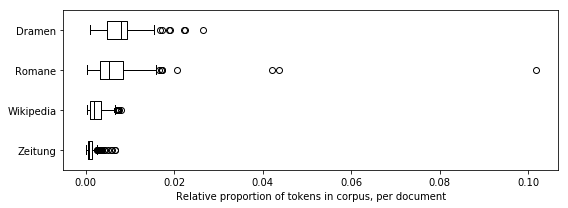

In [17]:
ax = s.plot.box(vert=False, color="black", figsize=(8,3))
ax.set_xlabel("Relative proportion of tokens in corpus, per document")
plt.tight_layout()
plt.savefig("corpus.svg")

In [18]:
df = pd.DataFrame(b).T

In [19]:
df.columns = df.loc["corpus"]

In [20]:
df = df.loc[:, ["Dramen", "Romane", "Wikipedia", "Zeitung"]]

In [25]:
s.to_csv("proportions.csv")

In [1]:
from classification import preprocessing

In [2]:
import pandas as pd
from pathlib import Path
import json
import operator
directory = "classification/data/full"

preprocessing.split_and_export(directory, downsample_corpus=True)

In [76]:
corpus1["length"] = corpus1["text"].apply(len)
corpus2["length"] = corpus2["text"].apply(len)
dist = corpus2["class"].value_counts()

lengths = [group["length"] for _, group in corpus2.groupby("class")]


downsampled = list()
for _, group in corpus1.groupby("class"):
    group = group.sort_values("length", ascending=False)
    idx = dist[_]
    cropped = [t[:lengths[_][i]] for i, t in enumerate(group["text"][:idx])]
    break

In [80]:
dist

0    73
1    57
2    43
Name: class, dtype: int64

In [81]:
def downsample(dataset, ratio=(73, 57, 43), random_state=23):
    a, b, c = tuple(set(dataset["class"]))
    a = dataset[dataset["class"] == a]
    b = dataset[dataset["class"] == b]
    c = dataset[dataset["class"] == c]
    random.seed(random_state)
    a_ = random.sample(list(a.index), ratio[0])
    b_ = random.sample(list(b.index), ratio[1])
    c_ = random.sample(list(b.index), ratio[2])
    a = a.iloc[[True if _ in a_ else False for _ in a.index]]
    b = b.iloc[[True if _ in b_ else False for _ in b.index]]
    c = c.iloc[[True if _ in c_ else False for _ in c.index]]
    return a.append(b).append(c)

In [84]:
import random
downsample(corpus1)

,_class,class,text,length
7,Kultur,0,Der Nationalismus in Russland nehme ständig zu...,1732
8,Kultur,0,"""La Rondine"" in der Regie von Rolando Villazon...",2921
10,Kultur,0,47-jährige Dramaturgin folgt auf Bettina Herin...,1271
12,Kultur,0,"""Die stillen Nächte des Ludwig Rainer"" feiert ...",2210
18,Kultur,0,Uraufführung des österreichischen Dramatikers ...,2677
29,Kultur,0,"In seinem neuen Kabarettprogramm ""Der Tolerato...",7630
42,Kultur,0,"""Der fliegende Holländer"" im Theater an der Wi...",3002
43,Kultur,0,"Die ""Dreigroschenoper "" in der Regie von Keith...",3804
54,Kultur,0,"Edler Gesang, greller Humor: Donizettis ""Don P...",2249
66,Kultur,0,Schwarzer Humor im Off-Theater: Das Bernhard-E...,3041
